In [1]:
# strategies

### Note I don't have to do all of these, maybe pick 2-3 that seem the most interesting

# Bayes approach, try a specific number of casts and select the one with the most fish

    # if there are ties, you could just randomly choose one, or you could do tournament style

    # between the tied lures

# Cast until you catch a fish, or until another lure has caught a fish sooner

# Make n casts until you don't catch a fish, then rotate

#

In [2]:
# make a cool visualization of the relationships between the various elements of the problem

 

# e.g., shorter time frame, more earning, less learning

# Closer payouts, harder to differentiate payouts, smaller difference between optimal strategy

# Less frequent payouts, each unit of learning learns less

# Switching cost, iterative learning is more expensive

# moving payouts, learning gets dated and needs to be done again

    #-- switching costs makes things even more complicated

In [403]:
# make this a separate file for ucb specific functions
def find_highest_ucb(ucb_dict):
    
    highest_estimate = -np.inf
    
    for lure in ucb_dict:
        
        temp_estimate = ucb_dict[lure]['ucb']
        
        if temp_estimate > highest_estimate:
            highest_estimate = temp_estimate
            highest_lure = lure
            
    return lure
        
        
        

In [418]:
import numpy as np
import random
from matplotlib import pyplot as plt

 

class MultiArmedFish():

   

    def __init__(self, lures, casts = 300):
        
        '''
            lures (dict) : dictionary containing the name of a lure 
                           with its corresponding catch probability
            casts (int)  : number of casts that will be taken in a given
                           fishing trip
        
        '''

        self.lures = lures
        self.casts = casts

        return
    
    def random_start(self, exclusions = []):
        
        '''
            choose one lure from attribute lures and return it with its 
            catch probability
            
            inputs:
                exclusions (list) : default = empty list - if populated
                                    gives lures to exclude from random 
                                    start
            
            outputs:
                random_lure (str) : dictionary key of randomly selected lure
                catr_prob (float) : probability of catching a fish for each cast
                                    with the lure (payout probability)
            
        '''
        
        if len(exclusions) == 0:
            random_lure, catch_prob = random.choice(list(self.lures.items()))
            
        else:
            # remove excluded lures from possible random starts by creating a new
            # dictionary without them in it
            temp_lures = {key: value for key, value in self.lures.items() if key not in exclusions}
            random_lure, catch_prob = random.choice(list(temp_lures.items()))
        
        return random_lure, catch_prob

   
    def multiple_simulations(self, strategy, iterations, **kwargs):
        
        '''
            Takes a strategy and runs in multiple times to get an 
            average number of catches for the strategy.
            
            inputs:
                strategy (str)      : name of the strategy - each name
                                      ties to a specific metric
                iterations (int)    : number of scenarios or 'fishing trips'
                                      to be run
                other key word args : any additional arguments needed for 
                                      specific strategies
        '''
        
        simulation_results = []
        
        for cast in range(0, iterations):
            
            if strategy == 'optimal':
                
                cast_success = self.optimal_strategy()
                
            elif strategy == 'one_round_learn':
                
                cast_success = self.one_round_learn(**kwargs)
                
            elif strategy == 'epsilon_greedy':
                
                cast_success = self.epsilon_greedy(**kwargs)
                
            elif strategy == 'random':
                
                cast_success = self.random()
                
            elif strategy == 'ucb':
                
                cast_success = self.ucb(**kwargs)
                
            elif strategy == 'eliminate_n':
                
                success_count = self.eliminate_n(**kwargs)
                
                cast_success = [True]*success_count
                
#             if isinstance(cast_success, list):
            simulation_results.append(np.sum(cast_success))
                
#             else:
#                 simulation_results.append(cast_success)
            
        print(f'mean catch = {np.mean(simulation_results)}')
        print(f'std catch = {np.std(simulation_results)}')
        print(f'historgram of fish caught with {strategy} strategy')
        plt.hist(simulation_results)
        plt.show() 
        
        return
    
    def simulate_cast(self, lure_pct, n = 1):
        
        '''
            Simple function to simulate a single cast using uniform random
            variable.
            
            inputs:
                lure_pct (float) : probability of catching with a specific
                                   lure
                n (int)          : number of casts to be simulated
                                   
            outputs:
                If n == 1:
                    catch_bool (bool) : True for catch, False for no catch
                If n > 1:
                    cast_success (list) : list of booleans for all n casts
        '''
        
        # run for single cast
        if n == 1:
            rand_num = np.random.uniform()
                
            if lure_pct >= rand_num:
                catch_bool = True
            
            else:
                catch_bool = False
            
            return catch_bool
        
        # run for multiple casts
        if n > 1:
            
            # create array of uniform numbers
            cast_values = np.random.uniform(size=n)
            cast_success = np.where(lure_pct >= cast_values, True, False)
            
            return cast_success
        
    

    def optimal_strategy(self):
        
        '''
            Serves as the benchmark to compare all strategies to.
            It simply selects the highest probability (which wouldn't be 
            known if practices) and only casts with that.
            
            inputs: None
            outputs: 
                cast_success (list) : list of 1's and 0's representing if a cast
                                      caught a fish or not
        
        '''

        lure_with_max_payout = max(self.lures, key=lambda key: lures[key])
        max_payout = self.lures[lure_with_max_payout]

        cast_success = self.simulate_cast(max_payout, n = self.casts)
   
        return cast_success


    def random(self):
        
        cast_success = []
        
        for cast in range(0, self.casts):
            random_lure, catch_prob = self.random_start()
            
            temp_cast_bool = self.simulate_cast(catch_prob)
            
            cast_success.append(temp_cast_bool)
            
        return cast_success
    
    
    def ucb(self, bound_multiplier):
        
        ucb_dict = {}
        # for each lure, create a list dicitonary of lists
        # that have UCB metrics
        for arm in self.lures:
            ucb_dict[arm] = {'success' : [],
                             'ucb'     : np.inf}
            
        cast_success = []
        
        # cast using UCB algorithm
        for cast in range(1, self.casts + 1):
            
            highest_ucb_lure = find_highest_ucb(ucb_dict)
            
            catch_bool = self.simulate_cast(self.lures[highest_ucb_lure])
            cast_success.append(catch_bool)
            # update ucb_dict for cast
            successes = ucb_dict[highest_ucb_lure]['success']
            successes.append(catch_bool)
            
            prob_estimate = np.mean(successes)
            ucb_estimate = prob_estimate + bound_multiplier*np.sqrt((np.log(cast))/len(successes))
            
            ucb_dict[highest_ucb_lure] = {'success' : successes,
                                          'ucb' : ucb_estimate}
            
            
            
            # find lure with highest ucb
            
        return cast_success
            

    
    # I should add a switch schedule, where we switch less frequently later in the
    # simulation, like simulated annealing
    def epsilon_greedy(self, epsilon, schedule = [1]):
        
        '''
            Starts with a random lure and gathers data on it,
            with a probability of epsilon at each cast, change the lure
            and gather data.  With a probability of 1-epsilon go back to 
            the lure with the highest payout
            
            inputs:
                epsilon (float) : probability used to randomly switch lures
                schedule (list) : factors to adjust epsilon based on 
                                  total number of casts - can be used 
                                  to lower the probability of switching later
                                  in trip - default = [1]
                
            outputs:
                cast_success (list) : list of 1's and 0's representing if a cast
                                      caught a fish or not
        
        '''
        
        # create a dictionary to keep track of observed catches
        obs_catch_dict = {}
        
        # start with a random lure
        curr_lure, curr_lure_pct = self.random_start()
        
        # populate dictionary with the first lure - give it an empty list as
        # the element
        
        # simulate the first cast
        first_cast_bool = self.simulate_cast(curr_lure_pct)
        cast_success = [first_cast_bool]
        
        # update dictionary to keep track of curr_lure's record
        obs_catch_dict[curr_lure] = [first_cast_bool]
        
        # set up casts number for each schedule amount
        casts_per_schedule = self.casts / len(schedule)
            
        
        # for the remaining casts, use the epsilon-greedy approach
        for cast in range(1, self.casts):
            
            switch_prob = np.random.uniform()
            
            # adjust epsilon if schedule provided
            adjustor = round((cast / casts_per_schedule) - 1)
            adj_epsilon = schedule[adjustor]
            
            # random switch
            if adj_epsilon >= switch_prob:
                
                # switch lures randomly
                curr_lure, curr_lure_pct = self.random_start(exclusions = [curr_lure])
                
                # simulate cast with switched lure
                temp_cast_bool = self.simulate_cast(curr_lure_pct)
                
                cast_success.append(temp_cast_bool)
                
                if curr_lure in obs_catch_dict.keys():
                    
                    # add results from current cast to dictionary of catches
                    temp_catch_list = obs_catch_dict[curr_lure]
                    temp_catch_list.append(temp_cast_bool)
                    obs_catch_dict[curr_lure] = temp_catch_list
                    
                else:
                    
                    # create a new element to keep track of lure's first cast
                    obs_catch_dict[curr_lure] = [temp_cast_bool]
            
            # switch to lure with highest payout
            else:
                
                # find lure with highest payout
                temp_catch_pct_dict = {}
                for lures, catches in obs_catch_dict.items():
                    catch_pct = np.sum(catches)/len(catches)
                    temp_catch_pct_dict[lures] = catch_pct
                    
                curr_lure = max(temp_catch_pct_dict, key=lambda key: temp_catch_pct_dict[key])
                
                
                # simulate cast with switched lure
                temp_cast_bool = self.simulate_cast(curr_lure_pct)
                    
                # add results from current cast to dictionary of catches
                temp_catch_list = obs_catch_dict[curr_lure]
                temp_catch_list.append(temp_cast_bool)
                obs_catch_dict[curr_lure] = temp_catch_list
                
                cast_success.append(temp_cast_bool)
                
        
        return cast_success
                
       

    def one_round_learn(self, num_tests, output_for_elminate_n = False,
                        output_for_elminate_dict = {}):
        
        '''
            Limits learn to one round, where each lure is used for
            num_tests casts and then the lure with the highest yeild 
            is used for all remaining casts
            
            inputs:
                num_test (int) :
                top_n_return (bool) : 
                
            returns:
            
        '''

        test_payouts = {}
        cast_count = 0

        # test each lure to decide which one to use for the
        # rest of the casts
        
        # use input ditionary if one is given
        if len(output_for_elminate_dict) == 0:
            
            lure_dict = self.lures
        
        else:
            lure_dict = output_for_elminate_dict
        
        # loop through lures
        for lure in lure_dict:

            lure_pct = lure_dict[lure]
            catch_list = []

            for test_cast in range(0, num_tests):

                cast_count += 1
                
                catch_bool = self.simulate_cast(lure_pct)
                catch_list.append(catch_bool)


            # now that test for this lure is done, count successes
            catches = np.sum(catch_list)
            test_payouts[lure] = catches
                
            
        # get highest catching lure
        best_lure = max(test_payouts, key=test_payouts.get)
        best_lure_pct = lures[best_lure]
        
        if output_for_elminate_n:
            return test_payouts, catches

        # now use remaining casts with the best lure from tests
        for remaining_cast in range(0, self.casts - cast_count):
                        
            catch_bool_best = self.simulate_cast(best_lure_pct)
            catch_list.append(catch_bool_best)

            
        catch_success = np.sum(catch_list)

        return catch_list
    

    
    def eliminate_n(self, n, num_tests):
        
        '''
        
            inputs:
                n (int) : number of lures to eliminate for each
                          iteration, higher is more aggressive as
                          more lures will be eliminated more quickly
        
        '''
        
        # finds top n performers and rotates through them
        # a few time until it finds the best overall
        lure_dict, catches = self.one_round_learn(num_tests, output_for_elminate_n = True)
        
        cast_count = num_tests*len(lure_dict)
        
        while len(lure_dict) > 1 and cast_count <= self.casts:
            
            # keep track of how many casts have been used
            cast_count += 1
            
            # Sort the dictionary by values in descending order
            sorted_dict = dict(sorted(lure_dict.items(), key=lambda item: item[1], reverse=True))

            # eliminate n elements
            n_keep = len(lure_dict) - n
            
            # if there are more than n elements, just 
            # select the highest valued lure and use that 
            # for the rest of the casts
            if n_keep < n:
                best_lure = list(sorted_dict.items())[0]
                break
            else:
                lure_dict, temp_catches = self.one_round_learn(num_tests, output_for_elminate_n = True, 
                                                               output_for_elminate_dict = lure_dict)
                catches += temp_catches
                
                lure_dict = dict(list(sorted_dict.items())[:n_keep])
                
        # now use remaining casts with the best lure from tests
        best_lure_pct = lure_dict[best_lure[0]]
        
        cast_count2 = 0
        
        for remaining_cast in range(0, self.casts - cast_count):
            
            cast_count2 += 1
                        
            catch_bool_best = self.simulate_cast(best_lure_pct)
            catches += np.sum(catch_bool_best)

            
        catch_success = catches
        
        print(cast_count + cast_count2)
                
        return catch_success



In [419]:
lures = {'crank bait' : 0.2,
         'spinner' : 0.01,
         'soft plastic' : 0.15,
         'rooster' : 0.10,
         'jerk bait' : 0.05}

mean catch = 60.077
std catch = 6.994931808102206
historgram of fish caught with optimal strategy


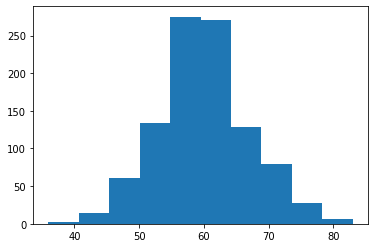

In [420]:
casts = 300
test_cast = MultiArmedFish(lures, casts)
test_cast.multiple_simulations('optimal', 1000)

mean catch = 14.756666666666666
std catch = 3.691989827842012
historgram of fish caught with ucb strategy


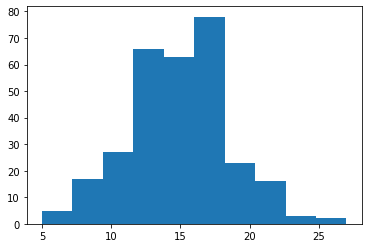

In [423]:
test_cast.multiple_simulations('ucb', 300, bound_multiplier = 500)

mean catch = 28.703333333333333
std catch = 7.1513627295005024
historgram of fish caught with epsilon_greedy strategy


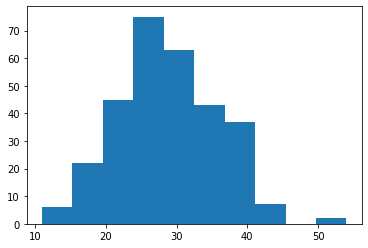

In [342]:
test_cast.multiple_simulations('epsilon_greedy', 300, epsilon = 0.10, schedule = [1, 0.5, 0.1, 0])

mean catch = 30.80666666666667
std catch = 5.090116785388021
historgram of fish caught with random strategy


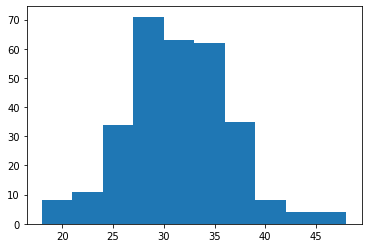

In [343]:
test_cast.multiple_simulations('random', 300)

mean catch = 51.09
std catch = 14.012681161481314
historgram of fish caught with one_round_learn strategy


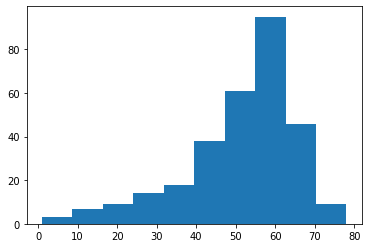

In [344]:
test_cast.multiple_simulations('one_round_learn', 300, num_tests = 2)

mean catch = 47.19
std catch = 14.102265775399356
historgram of fish caught with one_round_learn strategy


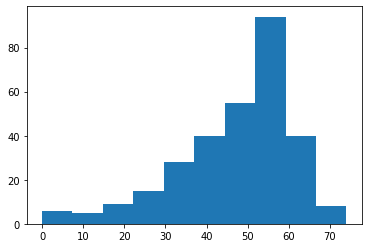

In [345]:
test_cast.multiple_simulations('one_round_learn', 300, num_tests = 5)

mean catch = 50.38666666666666
std catch = 12.603325839722713
historgram of fish caught with one_round_learn strategy


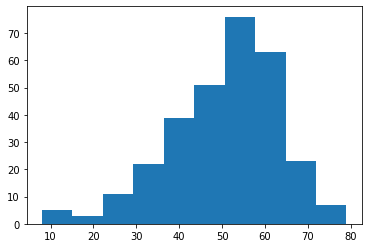

In [346]:
test_cast.multiple_simulations('one_round_learn', 300, num_tests = 3)

300
mean catch = 0.0
std catch = 0.0
historgram of fish caught with eliminate_n strategy


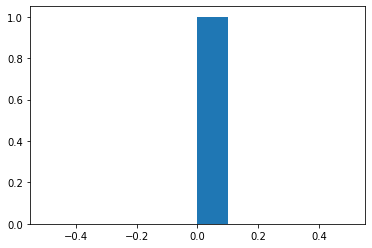

In [394]:
test_cast.multiple_simulations('eliminate_n', 1, n = 2, num_tests = 2)